# Advanced Lane Finding Project

In this project, The goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

The steps involved inthe pipeline are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The pipeline will be build progressively. 


---
## Import libraries

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## Camera Calibration
The goal of camera calibration is to compute the distortion of the image induced when the camera transforms a 3D object into a 2D image. The transformation is in general imperfect and distortion will change the shape and size of the objects. Once the distortion parameters of the camera are know, when can use them to inverse the distortion and recover correct information on the object. 

To compute the distortion, we need to 
* convert the image to grayscale,  
* use the function `cv2.findChessboardCorners` to automatically detect the corners
* use the `cv2.calibrateCamera` function
* apply the `cv2.undistort` function with parameters computed by the previous function to correct distortion in the following image.


In [13]:
def grayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


def plot_image(im):
    plt.figure()
    plt.imshow(im)
    plt.show()
    return


def plot_2_images(im1, im2, title1='Original Image', title2='Modified Image'):
    """
    Plot two images side-by-side for comparison.
    :param im1: Original image in BGR format
    :param im2: Modified image. Can be in different format 
    :param title1: Title to display above first image
    :param title2: Title to display on second image
    :return: 
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.tight_layout()
    # BGR to RGB conversion
    ax1.imshow(im1[:, :, ::-1])
    ax1.set_title(title1, fontsize=12)
    ax2.imshow(im2)
    ax2.set_title(title2, fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return


def plot_chessboard(img, ret, corners):
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    plot_image(img)
    return


def calibrate_chessboard(img, obj_points, img_points, plot=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    gray = grayscale(img)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    # If found, add object points, image points
    if ret:
        obj_points.append(objp)
        img_points.append(corners)
        if plot:
            plot_chessboard(img, ret, corners)

    return objpoints, imgpoints


def calibrate_multiple_chessboards(imglist):
    """
    Compute point correspondence on a list of images
    :param filelist: list of chessboard images
    :return: objpoints, imgpoints : two list with the correspondance between real space and image space.
    """
    # initialize object points and image points
    objpoints = []
    imgpoints = []

    # Step through the list and search for chessboard corners
    for fname in imglist:
        image = cv2.imread(fname)
        objpoints, imgpoints = calibrate_chessboard(image, objpoints, imgpoints)
    return objpoints, imgpoints, image.shape[:2]


def calibrate_camera(filelist):
    """
    calibrate camera using several picture taken with the camera.
    :param filelist: 
    :return: mtx : camera matrix, dist : distortion parameters 
    """
    # compute object/image points correspondence
    objpoints, imgpoints, shape = calibrate_multiple_chessboards(filelist)
    # Calibrate camera
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, shape[::-1], None, None)

    return mtx, dist


def undistort_image(img, M, dist):
    dst = cv2.undistort(img, M, dist, None, M)

    return dst

Now, we can test the calibration on some test images.

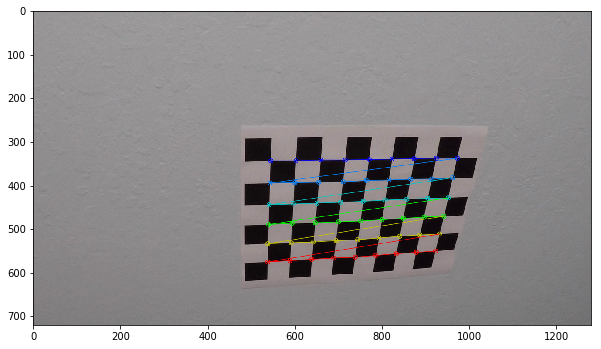

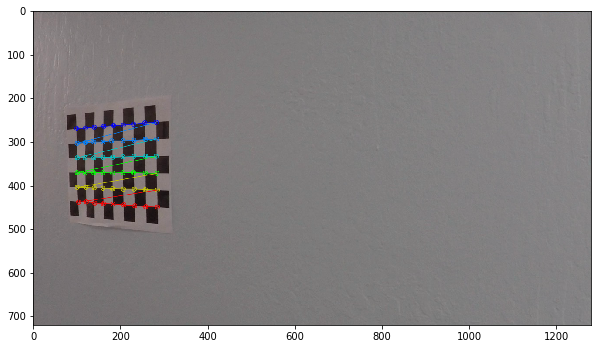

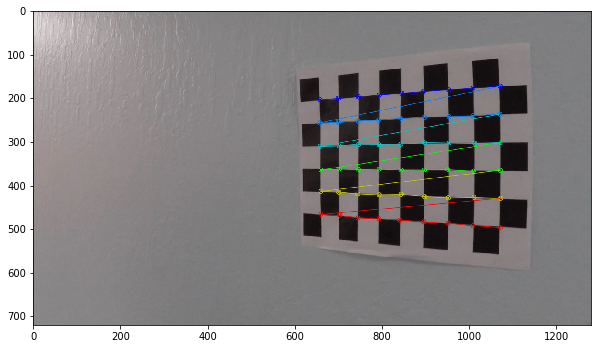

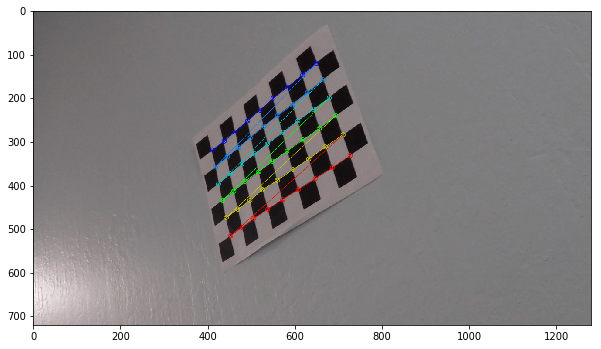

In [5]:
# initialize object points and image points
objpoints = []
imgpoints = []

# Make a list of calibration images
images = glob.glob('./CarND-Advanced-Lane-Lines-P4/camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images[:5]:
    image = cv2.imread(fname)
    objpoints, imgpoints = calibrate_chessboard(image, objpoints, imgpoints, plot = True)

Note that for some reason, the `cv2.findChessboardCorners` functions fails for image 'calibration1.jpg'. For all other images, it seems to find the corners correctly. We can also compute the distortion parameters of the camera :

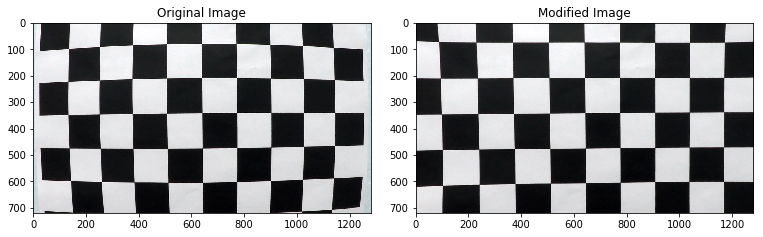

In [6]:
# Make a list of calibration images
images = glob.glob('./CarND-Advanced-Lane-Lines-P4/camera_cal/calibration*.jpg')
m, dist = calibrate_camera(images)
# Step through the list and search for chessboard corners
for fname in images[:1]:
    image = cv2.imread(fname)
    undist = undistort_image(image, m, dist)
    plot_2_images(image, undist)

The next steps is to use gradient and color thresholding to limit the image to relevant information. Let us start with gradient thresholding. We will use a combination of several gradient threshold criteria from :
- Gradient in the x direction
- Gradient in the y direction
- Magnitude of the gradient vector
- direction of the gradient vector

In [125]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobelxy / np.max(mag_sobelxy))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return binary_output


def combine_gradient_threshold(image, ksize=5, thresh_x=(30,100), thresh_y=(30,100), thresh_mag = (50,250), thresh_dir=(0.8,1.2)):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=thresh_x)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=thresh_y)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=thresh_mag)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=thresh_dir)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

Now let's make some tests. After several trials and finetuning, I settel on the following parameters :
* kernel size (for all the filters) : 15
* minimum and maximum gradients in the x and y directions : (50, 150)
* minimum and maximum gradient magnitude : (50, 150)
* maximum and minimum gradient direction : (0.8, 1.1)

Not that we included undistortion in the pipeline. The images shows the binary masks for the test_images after gradient thresholding. It is worh noting that at this point, we fail to recognize some of the yellow lines when there is a lot of light or when the soil is very clear. This will need to be chieved using colors thresholding.

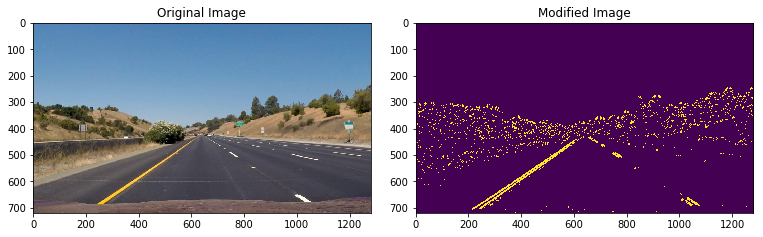

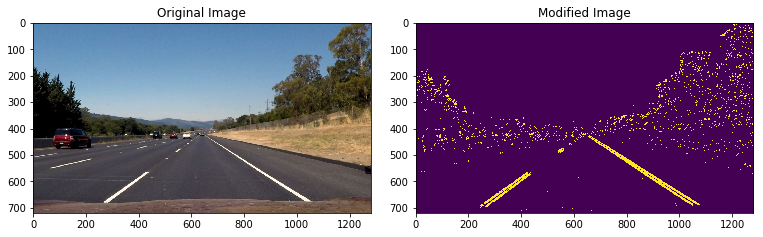

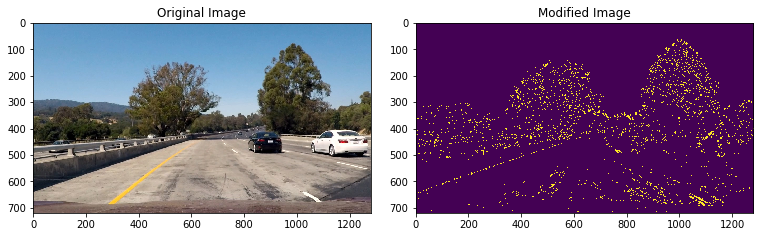

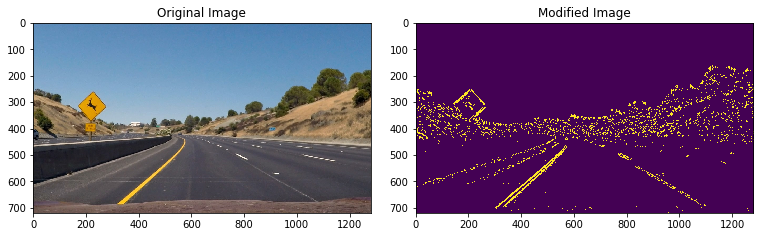

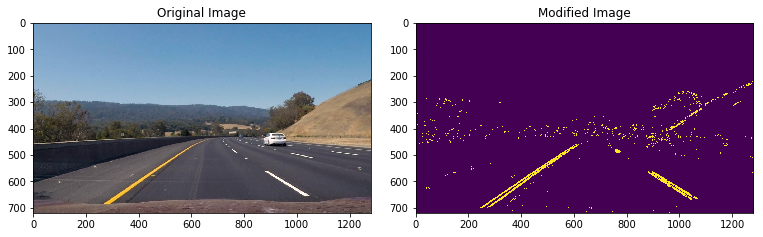

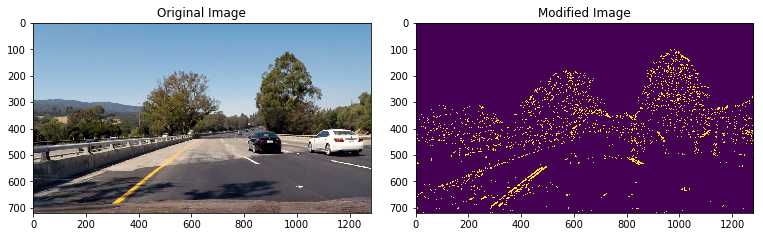

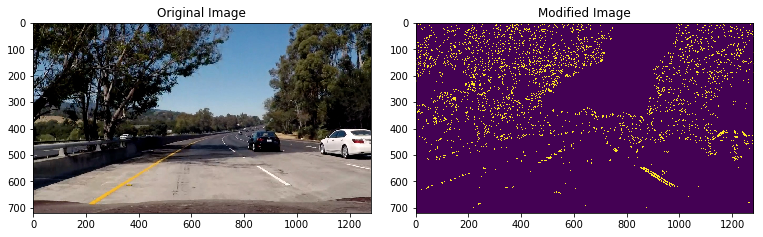

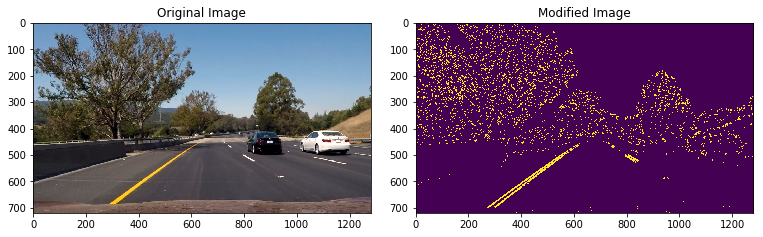

In [128]:
test_images = glob.glob('./CarND-Advanced-Lane-Lines-P4/test_images/*.jpg')
for test_image_fname in test_images:
    test_image = cv2.imread(test_image_fname)
    undist = undistort_image(test_image, m, dist)
    thresholded_image = combine_gradient_threshold(undist,ksize=15, thresh_x=(50,150), thresh_y=(50,150), thresh_mag = (20,255), thresh_dir=(0.8,1.1))
    plot_2_images(test_image, thresholded_image)